In [1]:
# CELL 1 (AFTER FACTORY RESET)

# Install necessary libraries
# Increased timeout for pip potentially helpful for large downloads like torch
!pip config set global.timeout 600

# Install libraries, letting pip resolve compatible versions where possible initially.
# Pin only faiss-cpu as it was the only one *not* causing direct conflicts initially.
!pip install -q \
    transformers \
    sentence-transformers \
    huggingface-hub \
    tokenizers \
    faiss-cpu==1.7.4 \
    torch \
    accelerate \
    scikit-learn \
    pandas \
    matplotlib \
    protobuf

# Note: Minimal pinning strategy for a fresh environment. Let pip try to sort it out.

Writing to /root/.config/pip/pip.conf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 80.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.5 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.

In [2]:
import json
import os
import random
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BartForSequenceClassification,
    BartTokenizer,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, hamming_loss, multilabel_confusion_matrix
from sklearn.preprocessing import LabelEncoder , MultiLabelBinarizer
from sentence_transformers import SentenceTransformer
import faiss
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Use notebook version of tqdm
import logging
import re
from typing import List, Dict, Tuple, Optional
import pickle
import gc # Garbage collector
import torch.nn.functional as F

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

2025-04-12 13:48:30.249481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744465710.475147      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744465710.540843      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# --- Hyperparameters ---
MAX_LEN = 512  # Increased for combined prompts
BATCH_SIZE = 8  # Smaller batch size due to longer sequences (Adjust based on GPU memory)
NUM_EPOCHS = 20 # Can be overridden later
LEARNING_RATE = 3e-5
EMBEDDING_DIM = 1024  # For BAAI/bge-m3
RETRIEVAL_K = 3  # Number of examples to retrieve
ADAM_BETA1 = 0.9
ADAM_BETA2 = 0.999
ADAM_EPSILON = 1e-8
WEIGHT_DECAY = 0.01
DROPOUT = 0.1

# --- Kaggle File Paths ---
# !!! ADJUST 'mental-health-meme-datasets' to your actual Kaggle dataset name !!!
KAGGLE_INPUT_DIR = "/kaggle/input/axiom-dataset"
KAGGLE_WORKING_DIR = "/kaggle/working"

# --- Output Directory Setup ---
# Will be set dynamically based on dataset choice later
# Example: OUTPUT_DIR = os.path.join(KAGGLE_WORKING_DIR, "anxiety", "output", "knowledge_fusion")

# --- Seed ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    logger.info(f"Seed set to {seed}")

set_seed(42)

# --- Device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

In [4]:
# CELL 4: Data Loading and Preprocessing Functions (Corrected Indentation)

import json
import os
import re
import numpy as np
import pandas as pd
import logging
from sklearn.model_selection import train_test_split

# Assume logger is configured from Cell 2
logger = logging.getLogger(__name__)

def load_data(file_path):
    """Load data, create 'stratify_label' for splitting, keep original labels."""
    logger.info(f"Loading data from: {file_path}")
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        logger.error(f"File not found: {file_path}")
        return []
    except json.JSONDecodeError:
         logger.error(f"Error decoding JSON from: {file_path}")
         return []

    is_anxiety = "Anxiety_Data" in file_path
    filtered_data = []
    processed_ids = set()

    for sample in data:
        if not isinstance(sample, dict):
            logger.warning(f"Skipping non-dictionary item in {file_path}")
            continue

        sample_id = sample.get('sample_id', sample.get('id', None))
        if sample_id is not None and sample_id in processed_ids:
            logger.warning(f"Skipping duplicate sample ID: {sample_id}")
            continue
        if sample_id is not None:
             processed_ids.add(sample_id)

        # Ensure triples exists
        if 'triples' not in sample or sample['triples'] is None:
            sample['triples'] = ""

        # --- Anxiety processing ---
        if is_anxiety:
            if 'ocr_text' in sample and 'meme_anxiety_category' in sample:
                # Fix spelling
                if sample['meme_anxiety_category'] == 'Irritatbily':
                    sample['meme_anxiety_category'] = 'Irritability'
                elif sample['meme_anxiety_category'] == 'Unknown':
                    sample['meme_anxiety_category'] = 'Unknown Anxiety'

                # Keep original label
                sample['original_labels'] = sample['meme_anxiety_category'] # Consistent field name
                # Label for stratification (single string)
                sample['stratify_label'] = sample['meme_anxiety_category']

                filtered_data.append(sample)
            else:
                 logger.warning(f"Skipping anxiety sample due to missing fields: {sample.get('sample_id', 'ID N/A')}")

         # --- Depression processing ---
        elif not is_anxiety:
             # Use the correct key name for depression labels
             depression_labels_key = 'meme_depressive_categories'
             if 'ocr_text' in sample and depression_labels_key in sample:
                # Keep original labels (list of strings) under 'original_labels'
                # Ensure it's a list (even if file has single string, though example shows list)
                original_label_data = sample.get(depression_labels_key, [])
                if isinstance(original_label_data, list):
                    sample['original_labels'] = original_label_data
                elif isinstance(original_label_data, str): # Handle case where it might be a single string
                    sample['original_labels'] = [original_label_data] if original_label_data else []
                else:
                    sample['original_labels'] = [] # Default to empty list

                # Label for stratification (use first label or placeholder)
                sample['stratify_label'] = sample['original_labels'][0] if sample['original_labels'] else "Unknown Depression"

                filtered_data.append(sample)
             else:
                 logger.warning(f"Skipping depression sample due to missing 'ocr_text' or '{depression_labels_key}': {sample.get('id', 'ID N/A')}")

    logger.info(f"Loaded {len(filtered_data)} samples after filtering.")
    return filtered_data


def clean_triples(triples_text):
    """Clean and extract structured information from triples text"""
    if pd.isna(triples_text) or not isinstance(triples_text, str) or not triples_text.strip():
        return ""

    # Extract key sections
    sections = ["Cause-Effect", "Figurative Understanding", "Mental State"]
    cleaned_text = ""

    for section in sections:
        # Regex to find section and capture content until next section or end of string
        # Handles potential variations in spacing and line breaks
        pattern = rf"{section}\s*:(.*?)(?=(?:{sections[0]}|{sections[1]}|{sections[2]})\s*:|$)"
        match = re.search(pattern, triples_text, re.IGNORECASE | re.DOTALL)
        if match:
            content = match.group(1).strip()
            # Further clean content: remove extra whitespace, maybe specific unwanted chars
            content = re.sub(r'\s+', ' ', content).strip()
            if content: # Only add if content is not empty after cleaning
                 cleaned_text += f"{section}: {content}\n"

    return cleaned_text.strip()


def split_data(data, val_size=0.1, test_size=0.2, random_state=42):
    """Split data into train, validation, and test sets using 'stratify_label'"""
    if not data:
        logger.error("Cannot split empty data.")
        return [], [], []

    try:
        # Use the new 'stratify_label' field for stratification
        strat_labels = [d['stratify_label'] for d in data]
    except KeyError:
        logger.error("Samples are missing 'stratify_label' key for stratification.")
        return [], [], []

    unique_labels, counts = np.unique(strat_labels, return_counts=True)
    labels_with_few_samples = unique_labels[counts < 2] # Need >= 2 samples for stratification

    if len(labels_with_few_samples) > 0:
         logger.warning(f"Labels for stratification with only one sample found: {labels_with_few_samples}. Removing these samples for splitting.")
         # Filter data and labels used for stratification
         original_indices_to_keep = {i for i, l in enumerate(strat_labels) if l not in labels_with_few_samples}
         data_filtered = [d for i, d in enumerate(data) if i in original_indices_to_keep]
         strat_labels_filtered = [l for i, l in enumerate(strat_labels) if i in original_indices_to_keep]

         if not data_filtered:
             logger.error("No data left after filtering single-sample labels for stratification.")
             return [], [], []
         data, strat_labels = data_filtered, strat_labels_filtered # Use filtered data and labels for splitting

    # If test_size is 0, split into train and val only
    if test_size == 0:
        if val_size <= 0 or val_size >= 1:
             logger.error("Invalid validation split size when test_size is 0.")
             return data, [], [] # Return all data as train, empty val
        try:
            # Stratify based on strat_labels
            train_data, val_data = train_test_split(
                data, test_size=val_size, random_state=random_state, stratify=strat_labels
            )
            return train_data, val_data, []
        except ValueError as e:
            # Fallback if stratification fails
            logger.error(f"Stratified split failed (test_size=0): {e}. Returning non-stratified split.")
            train_data, val_data = train_test_split(data, test_size=val_size, random_state=random_state)
            return train_data, val_data, []

    # Standard train/val/test split
    if test_size <= 0 or test_size >= 1:
         logger.error("Invalid test split size.")
         return [], [], data # Or raise error

    try:
        # First split: train+val and test, stratify based on strat_labels
        train_val_data, test_data = train_test_split(
            data, test_size=test_size, random_state=random_state, stratify=strat_labels
        )

        # Check if train_val_data is empty or too small for next split
        if not train_val_data:
             logger.error("train_val_data is empty after first split.")
             return [], [], test_data

        # Prepare for second split (train and val from train_val_data)
        train_val_strat_labels = [d['stratify_label'] for d in train_val_data]
        # Ensure there are enough samples in train_val_data for the split ratio
        val_ratio_abs = val_size / (1.0 - test_size) # Calculate absolute ratio for the second split

        if val_ratio_abs <= 0 or val_ratio_abs >= 1:
            logger.warning(f"Calculated validation ratio for second split ({val_ratio_abs:.2f}) is invalid. Adjusting.")
            # Fallback: e.g., use a fixed 80/20 split if train_val_data is large enough
            if len(train_val_data) >= 2:
                 val_ratio_fallback = 0.2
                 logger.warning(f"Using fallback validation ratio: {val_ratio_fallback}")
                 # Check if train_val_strat_labels has enough samples per class for fallback split
                 unique_tv_labels, tv_counts = np.unique(train_val_strat_labels, return_counts=True)
                 if any(tv_counts < 2):
                     logger.warning("Cannot stratify fallback split due to single samples. Using non-stratified.")
                     train_data, val_data = train_test_split(
                          train_val_data, test_size=val_ratio_fallback, random_state=random_state
                     )
                 else:
                     try:
                        train_data, val_data = train_test_split(
                            train_val_data, test_size=val_ratio_fallback, random_state=random_state, stratify=train_val_strat_labels
                        )
                     except ValueError: # Stratification might still fail
                         logger.warning("Stratified fallback split failed. Using non-stratified.")
                         train_data, val_data = train_test_split(
                              train_val_data, test_size=val_ratio_fallback, random_state=random_state
                         )
            else:
                 logger.error("train_val_data has less than 2 samples. Cannot split further.")
                 train_data = train_val_data
                 val_data = []
        else:
            # Perform the second split: train and val
             # Check if stratification is possible for the second split
             unique_tv_labels_split, tv_counts_split = np.unique(train_val_strat_labels, return_counts=True)
             if any(tv_counts_split < 2):
                 logger.warning("Cannot stratify second split due to single samples. Using non-stratified.")
                 train_data, val_data = train_test_split(
                     train_val_data, test_size=val_ratio_abs, random_state=random_state
                 )
             else:
                 try:
                     train_data, val_data = train_test_split(
                         train_val_data, test_size=val_ratio_abs, random_state=random_state, stratify=train_val_strat_labels
                     )
                 except ValueError as e_split: # Stratification might still fail
                     logger.warning(f"Stratified second split failed: {e_split}. Using non-stratified.")
                     train_data, val_data = train_test_split(
                         train_val_data, test_size=val_ratio_abs, random_state=random_state
                     )

    except ValueError as e: # Catch error from the first split attempt
        logger.error(f"Initial stratified split failed: {e}. Falling back to non-stratified splits.")
        # Fallback to non-stratified first split
        train_val_data, test_data = train_test_split(data, test_size=test_size, random_state=random_state)
        if not train_val_data:
             logger.error("train_val_data empty after non-stratified first split.")
             return [], [], test_data
        # Non-stratified second split
        val_ratio_abs = val_size / (1.0 - test_size)
        if 0 < val_ratio_abs < 1 and len(train_val_data) >= 2:
             train_data, val_data = train_test_split(train_val_data, test_size=val_ratio_abs, random_state=random_state)
        elif len(train_val_data) >= 1: # Keep remaining as train if split not possible/valid
             train_data = train_val_data
             val_data = []
        else: # Should be unreachable if first split check works
            train_data = []
            val_data = []

    # Final check for empty splits before returning
    if not train_data: logger.warning("Returning empty train_data.")
    if not val_data: logger.warning("Returning empty val_data.")
    if not test_data: logger.warning("Returning empty test_data.")

    return train_data, val_data, test_data

In [5]:
class EmbeddingGenerator:
    """Generate embeddings using SentenceTransformer"""
    def __init__(self, model_name="BAAI/bge-m3", device=None):
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        logger.info(f"Initializing SentenceTransformer model: {model_name} on device: {self.device}")
        try:
            self.model = SentenceTransformer(model_name, device=self.device)
            # Check embedding dimension
            test_emb = self.model.encode(["test sentence"])
            self.embedding_dim = test_emb.shape[1]
            logger.info(f"SentenceTransformer model loaded successfully. Embedding dimension: {self.embedding_dim}")
        except Exception as e:
            logger.error(f"Failed to load SentenceTransformer model: {e}")
            raise

    def generate_embeddings(self, texts: List[str], batch_size=32) -> Optional[np.ndarray]:
        """Generate embeddings for a list of texts"""
        if not texts:
            logger.warning("generate_embeddings called with empty list of texts.")
            return None
        logger.info(f"Generating embeddings for {len(texts)} texts...")
        try:
            embeddings = self.model.encode(texts, show_progress_bar=True,
                                           convert_to_numpy=True, batch_size=batch_size, device=self.device)
            logger.info(f"Embeddings generated with shape: {embeddings.shape}")
            return embeddings
        except Exception as e:
            logger.error(f"Error during embedding generation: {e}")
            # Handle potential OOM errors
            if "CUDA out of memory" in str(e):
                 logger.error("CUDA OOM error. Try reducing batch_size for encoding.")
            return None # Or raise the exception


    def generate_fused_embeddings(self, ocr_texts: List[str], triples_texts: List[str], batch_size=32) -> Optional[np.ndarray]:
        """Generate and concatenate normalized embeddings for OCR and triples"""
        logger.info("Generating fused embeddings...")
        if len(ocr_texts) != len(triples_texts):
             logger.error("Mismatch in lengths of ocr_texts and triples_texts.")
             return None

        ocr_embeddings = self.generate_embeddings(ocr_texts, batch_size=batch_size)
        # Handle cases where triples might be empty strings - generate zero vectors?
        # Or encode empty strings as well (model might handle it). Let's encode them.
        triples_embeddings = self.generate_embeddings(triples_texts, batch_size=batch_size)

        if ocr_embeddings is None or triples_embeddings is None:
            logger.error("Failed to generate embeddings for fusion.")
            return None

        # Normalize each embedding before concatenation
        ocr_norm = np.linalg.norm(ocr_embeddings, axis=1, keepdims=True)
        triples_norm = np.linalg.norm(triples_embeddings, axis=1, keepdims=True)

        # Avoid division by zero for zero vectors (e.g., from empty strings if model outputs zeros)
        ocr_embeddings_normalized = np.divide(ocr_embeddings, ocr_norm, out=np.zeros_like(ocr_embeddings), where=ocr_norm!=0)
        triples_embeddings_normalized = np.divide(triples_embeddings, triples_norm, out=np.zeros_like(triples_embeddings), where=triples_norm!=0)

        # Concatenate
        fused_embeddings = np.concatenate([ocr_embeddings_normalized, triples_embeddings_normalized], axis=1)
        logger.info(f"Fused embeddings generated with shape: {fused_embeddings.shape}")

        # Clean up memory
        del ocr_embeddings, triples_embeddings, ocr_embeddings_normalized, triples_embeddings_normalized
        gc.collect()

        return fused_embeddings

class RAGRetriever:
    """Retrieval-Augmented Generation system using FAISS for similarity search"""
    def __init__(self, embeddings: np.ndarray, top_k: int = RETRIEVAL_K):
        self.top_k = top_k
        self.index = None
        if embeddings is not None and embeddings.size > 0:
             self.build_index(embeddings)
        else:
             logger.warning("RAGRetriever initialized with no embeddings.")

    def build_index(self, embeddings: np.ndarray):
        """Build FAISS index for fast similarity search"""
        if embeddings is None or embeddings.shape[0] == 0:
             logger.error("Cannot build FAISS index with empty embeddings.")
             return
        dimension = embeddings.shape[1]
        logger.info(f"Building FAISS IndexFlatL2 with dimension {dimension} for {embeddings.shape[0]} vectors.")
        try:
            self.index = faiss.IndexFlatL2(dimension)
            # FAISS requires float32
            self.index.add(embeddings.astype(np.float32))
            logger.info(f"FAISS index built successfully. Index size: {self.index.ntotal}")
        except Exception as e:
            logger.error(f"Error building FAISS index: {e}")
            self.index = None # Ensure index is None if building failed

    def retrieve_similar(self, query_embeddings: np.ndarray) -> Optional[np.ndarray]:
        """Retrieve top-k similar example indices for each query embedding"""
        if self.index is None:
            logger.error("FAISS index is not built. Cannot retrieve.")
            return None
        if query_embeddings is None or query_embeddings.shape[0] == 0:
             logger.warning("retrieve_similar called with empty query embeddings.")
             return None

        # Ensure query is float32 and 2D
        query_embeddings = query_embeddings.astype(np.float32)
        if query_embeddings.ndim == 1:
            query_embeddings = np.expand_dims(query_embeddings, axis=0)

        k = min(self.top_k, self.index.ntotal) # Ensure k is not larger than the index size
        if k == 0:
            logger.warning("Index is empty, cannot retrieve.")
            return np.array([[] for _ in range(query_embeddings.shape[0])]) # Return empty arrays matching query shape

        logger.info(f"Searching for top {k} neighbors for {query_embeddings.shape[0]} queries.")
        try:
            distances, indices = self.index.search(query_embeddings, k=k)
            return indices
        except Exception as e:
            logger.error(f"Error during FAISS search: {e}")
            return None

class PromptConstructor:
    """Construct prompts for few-shot learning"""
    def __init__(self, train_data: List[Dict], label_encoder: LabelEncoder):
        self.train_data = train_data
        self.label_encoder = label_encoder
        self.class_names = ", ".join(label_encoder.classes_)
        logger.info(f"PromptConstructor initialized with {len(train_data)} training examples.")

    def construct_prompt(self, sample: Dict, retrieved_indices: Optional[List[int]] = None) -> str:
        """Construct a prompt with retrieved examples"""
        system_instruction = f"Classify the meme based on its category. Choose from: {self.class_names}."

        prompt = f"{system_instruction}\n\n"

        # Add retrieved examples if provided and valid
        if retrieved_indices is not None and len(retrieved_indices) > 0:
            prompt += "Here are some similar examples:\n\n"
            for idx in retrieved_indices:
                # Safety check for index bounds
                if 0 <= idx < len(self.train_data):
                    ex = self.train_data[idx]
                    ex_text = ex.get("ocr_text", "N/A")
                    ex_triples = ex.get("triples", "") # Already cleaned
                    ex_label = ex.get("meme_anxiety_category", "N/A")

                    prompt += f"Example Text: {ex_text}\n"
                    if ex_triples: # Only add if triples are non-empty
                        prompt += f"Example Knowledge: {ex_triples}\n"
                    prompt += f"Category: {ex_label}\n\n"
                else:
                    logger.warning(f"Retrieved index {idx} is out of bounds for train_data.")

            prompt += "Now classify this new example:\n\n"

        # Add the current sample details
        current_text = sample.get('ocr_text', 'N/A')
        current_triples = sample.get('triples', '') # Already cleaned

        prompt += f"Text: {current_text}\n"
        if current_triples: # Only add if triples are non-empty
            prompt += f"Knowledge: {current_triples}\n"
        prompt += "Category:" # Model should predict the category after this

        return prompt

In [6]:
class AnxietyDataset(Dataset):
    """Dataset for SINGLE-LABEL anxiety meme classification"""
    def __init__(self, samples: List[Dict], prompts: List[str], tokenizer: BartTokenizer, max_len: int, label_encoder: LabelEncoder):
        self.samples = samples
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_encoder = label_encoder
        logger.info(f"AnxietyDataset (Single-Label) created with {len(samples)} samples.")
        if len(samples) != len(prompts):
            logger.warning(f"Mismatch between samples ({len(samples)}) and prompts ({len(prompts)}).")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        prompt = self.prompts[idx]
        # Use the original label string
        label_str = sample.get("original_labels", None)

        if label_str is None:
             logger.error(f"Sample {idx} missing 'original_labels'. Assigning default 0.")
             label_idx = 0
        else:
            try:
                 # Single label: transform string to integer index
                 label_idx = self.label_encoder.transform([label_str])[0]
            except ValueError:
                 logger.error(f"Label '{label_str}' not found in LabelEncoder. Assigning default 0.")
                 label_idx = 0

        encoding = self.tokenizer(
            prompt,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            # Return label as Long tensor for CrossEntropyLoss (implicitly used)
            "label": torch.tensor(label_idx, dtype=torch.long),
        }

class DepressionDataset(Dataset):
    """Dataset for MULTI-LABEL depression meme classification"""
    def __init__(self, samples: List[Dict], prompts: List[str], tokenizer: BartTokenizer, max_len: int, label_encoder: LabelEncoder):
        self.samples = samples
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_encoder = label_encoder
        self.num_labels = len(label_encoder.classes_)
        logger.info(f"DepressionDataset (Multi-Label) created with {len(samples)} samples and {self.num_labels} total labels.")
        if len(samples) != len(prompts):
            logger.warning(f"Mismatch between samples ({len(samples)}) and prompts ({len(prompts)}).")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        prompt = self.prompts[idx]
        # Use the original labels list
        label_str_list = sample.get("original_labels", [])

        # Create multi-hot encoded vector
        multi_hot_label = torch.zeros(self.num_labels, dtype=torch.float)
        if not label_str_list:
             logger.warning(f"Sample {idx} has empty 'original_labels' list.")
        else:
            for label_str in label_str_list:
                try:
                    label_idx = self.label_encoder.transform([label_str])[0]
                    multi_hot_label[label_idx] = 1.0
                except ValueError:
                    logger.warning(f"Label '{label_str}' in sample {idx} not found in LabelEncoder. Skipping this label.")
                except IndexError:
                     logger.error(f"Index out of bounds for label '{label_str}' (index {label_idx}) in sample {idx}. Label encoder size: {self.num_labels}")


        encoding = self.tokenizer(
            prompt,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            # Return label as Float tensor for BCEWithLogitsLoss
            "label": multi_hot_label,
        }

In [7]:
class AnxietyClassifierWithFusion(nn.Module):
    """BART-based classifier adaptable for single/multi-label tasks"""
    def __init__(self, num_labels: int, pretrained_model: str = "facebook/bart-base", is_multilabel: bool = False):
        super(AnxietyClassifierWithFusion, self).__init__()
        self.num_labels = num_labels
        self.is_multilabel = is_multilabel
        logger.info(f"Initializing BartForSequenceClassification from: {pretrained_model}")
        logger.info(f"Model configured for {'Multi-Label' if is_multilabel else 'Single-Label'} classification with {num_labels} labels.")
        try:
            # Load the standard sequence classification model
            self.bart = BartForSequenceClassification.from_pretrained(
                pretrained_model,
                num_labels=num_labels,
                classifier_dropout=DROPOUT,
                # Set problem_type for multi-label loss calculation if needed by HF internals
                # However, we'll calculate loss manually for BCE
                problem_type="multi_label_classification" if is_multilabel else "single_label_classification",
                ignore_mismatched_sizes=True # Allow loading weights even if head size mismatches (will be retrained)

            )
        except Exception as e:
            logger.error(f"Failed to load pretrained BART model: {e}")
            raise

        # Define loss function for multi-label case
        if self.is_multilabel:
            self.loss_fct = nn.BCEWithLogitsLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        # Get outputs from the underlying BartForSequenceClassification model
        outputs = self.bart(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels if not self.is_multilabel else None # Pass labels only for single-label internal loss calculation
            # If multi-label, HF won't calculate BCE loss correctly with this model if labels are floats, so pass None
        )

        loss = None
        # If multi-label and labels are provided, calculate BCEWithLogitsLoss manually
        if self.is_multilabel and labels is not None:
             logits = outputs.logits
             # Ensure labels are float type for BCE loss
             loss = self.loss_fct(logits, labels.float())
             # Put the calculated loss back into the outputs object
             outputs.loss = loss

        # For single-label, loss is already calculated internally by BartForSequenceClassification if labels were passed
        # If evaluating (labels=None), loss will be None in both cases

        return outputs # Return the standard SequenceClassifierOutput object

In [8]:
# CELL 8: Training and Evaluation Function (Modified for Single/Multi-Label)

def train_and_evaluate(
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    device: torch.device,
    num_epochs: int,
    output_dir: str,
    label_encoder: LabelEncoder, # Pass label encoder for reporting
    is_multilabel: bool # Flag to indicate mode
):
    """Training and evaluation function adaptable for single/multi-label tasks."""
    os.makedirs(output_dir, exist_ok=True)
    logger.info(f"Outputs will be saved to: {output_dir}")
    logger.info(f"Running in {'Multi-Label' if is_multilabel else 'Single-Label'} mode.")

    best_val_f1_macro = 0.0 # Use validation macro F1 for saving best model (consistent)
    best_model_path = os.path.join(output_dir, "best_model.pt")
    last_model_path = os.path.join(output_dir, "last_model.pt")
    log_file = os.path.join(output_dir, "training_logs.csv")
    logs = []

    # Initialize history dictionary - added micro F1
    history = {
        'train_loss': [], 'val_loss': [],
        'train_f1_macro': [], 'val_f1_macro': [],
        'train_f1_micro': [], 'val_f1_micro': [],
        'train_f1_weighted': [], 'val_f1_weighted': [],
        'val_accuracy': [], 'val_hamming': []
    }

    total_steps = len(train_dataloader) * num_epochs
    logger.info(f"Starting training for {num_epochs} epochs ({total_steps} total steps).")

    try:
        for epoch in range(num_epochs):
            epoch_num = epoch + 1
            logger.info(f"--- Epoch {epoch_num}/{num_epochs} ---")

            # --- Training Phase ---
            model.train()
            train_loss_epoch = 0
            # Store logits and raw labels (int or float tensor) for epoch-end metric calculation
            all_train_logits, all_train_labels_raw = [], []
            train_progress = tqdm(train_dataloader, desc=f"Training Epoch {epoch_num}", leave=False)

            for batch_idx, batch in enumerate(train_progress):
                optimizer.zero_grad()
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device) # Labels are Long (single) or Float (multi-hot)

                try:
                    # Forward pass - model calculates loss internally based on its is_multilabel flag
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                    if loss is None:
                         logger.error("Loss is None during training. Check model forward pass and labels.")
                         continue

                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    scheduler.step()

                    train_loss_epoch += loss.item()

                    # Store results for epoch-level metrics
                    all_train_logits.append(outputs.logits.detach().cpu())
                    all_train_labels_raw.append(labels.cpu())

                    train_progress.set_postfix({"Loss": f"{loss.item():.4f}", "LR": f"{scheduler.get_last_lr()[0]:.2e}"})

                except Exception as e:
                     logger.error(f"Error in training batch {batch_idx}: {e}")
                     # Optional: Add more handling like skipping batch

            avg_train_loss = train_loss_epoch / len(train_dataloader) if len(train_dataloader) > 0 else 0

            # --- Calculate Training Metrics (End of Epoch) ---
            all_train_logits_cat = torch.cat(all_train_logits, dim=0)
            all_train_labels_raw_cat = torch.cat(all_train_labels_raw, dim=0)

            if is_multilabel:
                train_probs = torch.sigmoid(all_train_logits_cat).numpy()
                train_preds = (train_probs > 0.5).astype(int) # Thresholding
                train_labels = all_train_labels_raw_cat.numpy().astype(int) # Ground truth
                train_f1_micro = f1_score(train_labels, train_preds, average="micro", zero_division=0)
                train_f1_macro = f1_score(train_labels, train_preds, average="macro", zero_division=0)
                train_f1_weighted = f1_score(train_labels, train_preds, average="weighted", zero_division=0)
                logger.info(f"Epoch {epoch_num} Training - Loss: {avg_train_loss:.4f}, Micro F1: {train_f1_micro:.4f}, Macro F1: {train_f1_macro:.4f}")
            else: # Single-label
                train_preds = torch.argmax(all_train_logits_cat, dim=1).numpy()
                train_labels = all_train_labels_raw_cat.numpy()
                train_f1_micro = f1_score(train_labels, train_preds, average="micro", zero_division=0) # Can still calculate
                train_f1_macro = f1_score(train_labels, train_preds, average="macro", zero_division=0)
                train_f1_weighted = f1_score(train_labels, train_preds, average="weighted", zero_division=0)
                logger.info(f"Epoch {epoch_num} Training - Loss: {avg_train_loss:.4f}, Macro F1: {train_f1_macro:.4f}, Weighted F1: {train_f1_weighted:.4f}")

            # --- Validation Phase ---
            model.eval()
            val_loss_epoch = 0
            # Store logits and raw labels for epoch-end metric calculation
            all_val_logits, all_val_labels_raw = [], []
            val_progress = tqdm(val_dataloader, desc=f"Validating Epoch {epoch_num}", leave=False)

            with torch.no_grad():
                for batch in val_progress:
                    input_ids = batch["input_ids"].to(device)
                    attention_mask = batch["attention_mask"].to(device)
                    labels = batch["label"].to(device)

                    try:
                        # Forward pass - model calculates loss internally based on its is_multilabel flag
                        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                        if outputs.loss is not None:
                             val_loss_epoch += outputs.loss.item()

                        # Store results for epoch-level metrics
                        all_val_logits.append(outputs.logits.cpu())
                        all_val_labels_raw.append(labels.cpu())

                    except Exception as e:
                        logger.error(f"Error in validation batch: {e}")

            avg_val_loss = val_loss_epoch / len(val_dataloader) if len(val_dataloader) > 0 else 0

            # --- Calculate Validation Metrics (End of Epoch) ---
            all_val_logits_cat = torch.cat(all_val_logits, dim=0)
            all_val_labels_raw_cat = torch.cat(all_val_labels_raw, dim=0)

            if is_multilabel:
                val_probs = torch.sigmoid(all_val_logits_cat).numpy()
                val_preds = (val_probs > 0.5).astype(int) # Thresholding
                val_labels = all_val_labels_raw_cat.numpy().astype(int)
                val_accuracy = accuracy_score(val_labels, val_preds) # Subset accuracy
                val_hamming = hamming_loss(val_labels, val_preds)
                val_f1_micro = f1_score(val_labels, val_preds, average="micro", zero_division=0)
                val_f1_macro = f1_score(val_labels, val_preds, average="macro", zero_division=0)
                val_f1_weighted = f1_score(val_labels, val_preds, average="weighted", zero_division=0)
                logger.info(f"Epoch {epoch_num} Validation - Loss: {avg_val_loss:.4f}, Subset Acc: {val_accuracy:.4f}, Hamming: {val_hamming:.4f}, Micro F1: {val_f1_micro:.4f}, Macro F1: {val_f1_macro:.4f}")
            else: # Single-label
                val_preds = torch.argmax(all_val_logits_cat, dim=1).numpy()
                val_labels = all_val_labels_raw_cat.numpy()
                val_accuracy = accuracy_score(val_labels, val_preds) # Standard accuracy
                val_hamming = hamming_loss(val_labels, val_preds) # Hamming can be calculated
                val_f1_micro = f1_score(val_labels, val_preds, average="micro", zero_division=0) # Can be calculated
                val_f1_macro = f1_score(val_labels, val_preds, average="macro", zero_division=0)
                val_f1_weighted = f1_score(val_labels, val_preds, average="weighted", zero_division=0)
                logger.info(f"Epoch {epoch_num} Validation - Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Macro F1: {val_f1_macro:.4f}, Weighted F1: {val_f1_weighted:.4f}")


            # --- Update History and Logs ---
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)
            history['train_f1_macro'].append(train_f1_macro)
            history['val_f1_macro'].append(val_f1_macro)
            history['train_f1_micro'].append(train_f1_micro) # Store micro
            history['val_f1_micro'].append(val_f1_micro)   # Store micro
            history['train_f1_weighted'].append(train_f1_weighted)
            history['val_f1_weighted'].append(val_f1_weighted)
            history['val_accuracy'].append(val_accuracy) # Store accuracy (subset or standard)
            history['val_hamming'].append(val_hamming)

            # Update log dictionary for saving
            current_log = {
                "epoch": epoch_num,
                "train_loss": avg_train_loss, "train_f1_macro": train_f1_macro, "train_f1_micro": train_f1_micro, "train_f1_weighted": train_f1_weighted,
                "val_loss": avg_val_loss, "val_accuracy": val_accuracy, "val_f1_macro": val_f1_macro, "val_f1_micro": val_f1_micro,
                "val_f1_weighted": val_f1_weighted, "val_hamming": val_hamming,
            }
            logs.append(current_log)

            # --- Save Model ---
            # Save the best model based on validation macro F1 (consistent choice)
            if val_f1_macro > best_val_f1_macro:
                best_val_f1_macro = val_f1_macro
                torch.save(model.state_dict(), best_model_path)
                logger.info(f"Epoch {epoch_num}: New best model saved with Macro F1: {best_val_f1_macro:.4f}")

            # Save the last model state
            torch.save(model.state_dict(), last_model_path)

            # Save logs to CSV after every epoch
            pd.DataFrame(logs).to_csv(log_file, index=False)

            # Optional: Clear GPU cache if memory is tight
            if device == torch.device('cuda'):
                torch.cuda.empty_cache()
                gc.collect()

        logger.info(f"Training finished. Best validation Macro F1: {best_val_f1_macro:.4f}")
        logger.info(f"Best model saved to {best_model_path}")
        logger.info(f"Last model saved to {last_model_path}")
        logger.info(f"Training logs saved to {log_file}")

    except Exception as e:
        logger.error(f"Critical error during training loop: {e}")
        # Save partial logs if error occurs
        pd.DataFrame(logs).to_csv(log_file, index=False)
        logger.info(f"Partial logs saved to {log_file} due to error.")
        raise # Re-raise the exception

    return history

In [9]:
def plot_training_history(history: Dict, output_dir: str):
    """Plot training and validation metrics and save the plot."""
    if not history or not isinstance(history, dict):
        logger.warning("No valid training history provided for plotting.")
        return

    num_epochs = len(history.get('train_loss', []))
    if num_epochs == 0:
        logger.warning("Training history is empty, cannot plot.")
        return

    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(15, 10))

    # Plot Loss
    if 'train_loss' in history and 'val_loss' in history:
        plt.subplot(2, 2, 1)
        plt.plot(epochs_range, history['train_loss'], label='Train Loss', marker='o')
        plt.plot(epochs_range, history['val_loss'], label='Validation Loss', marker='o')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

    # Plot F1 Macro
    if 'train_f1_macro' in history and 'val_f1_macro' in history:
        plt.subplot(2, 2, 2)
        plt.plot(epochs_range, history['train_f1_macro'], label='Train Macro F1', marker='o')
        plt.plot(epochs_range, history['val_f1_macro'], label='Validation Macro F1', marker='o')
        plt.title('Training and Validation Macro F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid(True)

    # Plot F1 Weighted
    if 'train_f1_weighted' in history and 'val_f1_weighted' in history:
        plt.subplot(2, 2, 3)
        plt.plot(epochs_range, history['train_f1_weighted'], label='Train Weighted F1', marker='o')
        plt.plot(epochs_range, history['val_f1_weighted'], label='Validation Weighted F1', marker='o')
        plt.title('Training and Validation Weighted F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid(True)

    # Plot Validation Accuracy and Hamming Loss (optional)
    if 'val_accuracy' in history and 'val_hamming' in history:
         plt.subplot(2, 2, 4)
         plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy', marker='o', color='green')
         plt.plot(epochs_range, history['val_hamming'], label='Validation Hamming Loss', marker='o', color='red')
         plt.title('Validation Accuracy & Hamming Loss')
         plt.xlabel('Epoch')
         plt.ylabel('Metric Value')
         plt.legend()
         plt.grid(True)


    plt.tight_layout()
    plot_path = os.path.join(output_dir, 'training_history.png')
    try:
        plt.savefig(plot_path)
        logger.info(f"Training history plot saved to {plot_path}")
    except Exception as e:
         logger.error(f"Failed to save training plot: {e}")
    plt.show() # Display the plot in the notebook

In [10]:
# CELL 10: Evaluation Function (Adapted for Single/Multi-Label)

def evaluate_model(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
    label_encoder: LabelEncoder,
    is_multilabel: bool, # Flag to determine mode
    num_labels: int, # Needed for multi-label report/metrics
    output_dir: str, # Directory to save detailed reports
    report_suffix: str = "eval" # Suffix for report filenames (e.g., "validation_best", "test_best")
    ) -> Dict:
    """Evaluate the model on the given dataloader and return metrics, adapting for single/multi-label."""

    if not dataloader:
        logger.warning(f"Evaluation dataloader ({report_suffix}) is empty or None. Skipping evaluation.")
        # Return a dictionary with expected keys but default values
        return {
            'accuracy': 0, 'macro_f1': 0, 'weighted_f1': 0, 'hamming_loss': 1,
            'micro_f1': 0, 'samples_f1': 0,
            'report': "No data to evaluate."
            }

    model.eval()
    all_logits = []
    all_labels_raw = [] # Store raw labels (int indices or multi-hot vectors)
    logger.info(f"Starting evaluation ({report_suffix}) on {len(dataloader.dataset)} samples...")
    eval_progress = tqdm(dataloader, desc=f"Evaluating ({report_suffix})", leave=False)

    with torch.no_grad():
        for batch in eval_progress:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device) # Ground truth labels

            try:
                # Forward pass without labels for evaluation
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=None)
                all_logits.append(outputs.logits.cpu())
                all_labels_raw.append(labels.cpu())
            except Exception as e:
                 logger.error(f"Error during evaluation batch ({report_suffix}): {e}")
                 # Optionally, decide whether to skip batch or halt

    # Check if any results were collected
    if not all_labels_raw or not all_logits:
         logger.warning(f"Evaluation ({report_suffix}) resulted in empty predictions or labels. Cannot calculate metrics.")
         return {
             'accuracy': 0, 'macro_f1': 0, 'weighted_f1': 0, 'hamming_loss': 1,
             'micro_f1': 0, 'samples_f1': 0,
             'report': "Evaluation failed or yielded no results."
             }

    # Concatenate results from all batches
    all_logits_cat = torch.cat(all_logits, dim=0)
    all_labels_raw_cat = torch.cat(all_labels_raw, dim=0)

    # --- Calculate Metrics based on mode ---
    metrics_dict = {}
    report = "Report generation failed." # Default report

    try:
        if is_multilabel:
            logger.info(f"Calculating multi-label metrics for {report_suffix}...")
            probs = torch.sigmoid(all_logits_cat).numpy()
            # Use threshold 0.5 for predictions
            preds = (probs > 0.5).astype(int)
            labels = all_labels_raw_cat.numpy().astype(int) # Ground truth multi-hot

            accuracy = accuracy_score(labels, preds) # Exact match ratio (subset accuracy)
            hamming = hamming_loss(labels, preds)
            f1_micro = f1_score(labels, preds, average='micro', zero_division=0)
            f1_macro = f1_score(labels, preds, average='macro', zero_division=0)
            f1_weighted = f1_score(labels, preds, average='weighted', zero_division=0)
            f1_samples = f1_score(labels, preds, average='samples', zero_division=0)

            # Generate multi-label classification report
            report = classification_report(
                labels, preds,
                target_names=label_encoder.classes_,
                digits=4,
                zero_division=0
            )
            # Also log confusion matrix per label
            cm = multilabel_confusion_matrix(labels, preds)
            cm_report_path = os.path.join(output_dir, f"confusion_matrix_{report_suffix}.txt")
            with open(cm_report_path, "w") as f:
                 f.write("Multilabel Confusion Matrix (per label):\n")
                 for i, label_name in enumerate(label_encoder.classes_):
                     f.write(f"\nLabel: {label_name}\n")
                     f.write(f"{cm[i]}\n") # TN, FP / FN, TP
            logger.info(f"Multilabel confusion matrix saved to {cm_report_path}")

            metrics_dict = {
                'accuracy': accuracy, # Subset accuracy
                'hamming_loss': hamming,
                'micro_f1': f1_micro,
                'macro_f1': f1_macro,
                'weighted_f1': f1_weighted,
                'samples_f1': f1_samples,
                'report': report
            }

        else: # Single-label
            logger.info(f"Calculating single-label metrics for {report_suffix}...")
            preds = torch.argmax(all_logits_cat, dim=1).numpy()
            labels = all_labels_raw_cat.numpy() # Ground truth indices

            accuracy = accuracy_score(labels, preds)
            hamming = hamming_loss(labels, preds) # Can still be calculated
            f1_micro = f1_score(labels, preds, average='micro', zero_division=0)
            f1_macro = f1_score(labels, preds, average='macro', zero_division=0)
            f1_weighted = f1_score(labels, preds, average='weighted', zero_division=0)
            # f1_samples is less meaningful for single-label but calculate for consistency if needed
            f1_samples = f1_score(labels, preds, average='samples', zero_division=0)

            # Generate single-label classification report
            unique_numeric_labels = sorted(list(set(labels) | set(preds)))
            # Ensure labels exist in the encoder before getting names
            present_class_names = [label_encoder.classes_[i] for i in unique_numeric_labels if i < len(label_encoder.classes_)]
            numeric_labels_in_encoder = [i for i in unique_numeric_labels if i < len(label_encoder.classes_)]

            if not numeric_labels_in_encoder: # Handle case where no valid labels are predicted/present
                logger.warning(f"No valid labels found in predictions/ground truth for {report_suffix} report.")
                report = "No valid labels to report on."
            else:
                report = classification_report(
                    labels, preds,
                    labels=numeric_labels_in_encoder, # Use numeric labels corresponding to known classes
                    target_names=present_class_names,
                    digits=4,
                    zero_division=0
                )

            metrics_dict = {
                'accuracy': accuracy,
                'hamming_loss': hamming,
                'micro_f1': f1_micro,
                'macro_f1': f1_macro,
                'weighted_f1': f1_weighted,
                'samples_f1': f1_samples,
                'report': report
            }

    except Exception as e:
        logger.error(f"Error calculating metrics or generating report for {report_suffix}: {e}")
        # Return default values in case of error during metric calculation
        metrics_dict = {
             'accuracy': 0, 'macro_f1': 0, 'weighted_f1': 0, 'hamming_loss': 1,
             'micro_f1': 0, 'samples_f1': 0,
             'report': f"Error during metric calculation: {e}"
             }

    # Save the main classification report
    report_path = os.path.join(output_dir, f"classification_report_{report_suffix}.txt")
    try:
        with open(report_path, "w") as f:
             f.write(f"--- Evaluation Metrics ({report_suffix}) ---\n")
             for key, value in metrics_dict.items():
                 if key != 'report':
                     f.write(f"{key.replace('_', ' ').title()}: {value:.4f}\n")
             f.write("\n--- Classification Report ---\n")
             f.write(metrics_dict.get('report', 'Report generation failed.'))
        logger.info(f"Classification report saved to {report_path}")
    except Exception as e:
         logger.error(f"Failed to save classification report for {report_suffix}: {e}")


    logger.info(f"Evaluation ({report_suffix}) complete.")
    return metrics_dict

In [11]:
# CELL 11: Prediction Function (Adapted for Single/Multi-Label)

def predict(
    model: nn.Module,
    tokenizer: BartTokenizer,
    label_encoder: LabelEncoder,
    text: str,
    triples: str="",
    device: torch.device = None,
    max_length: int = MAX_LEN,
    is_multilabel: bool = False, # Flag to determine mode
    threshold: float = 0.5 # Threshold for multi-label predictions
    ) -> Dict:
    """Make prediction for a single example, adapting for single/multi-label."""

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device) # Ensure model is on the correct device
    model.eval()

    # Construct prompt (remains the same, model handles classification type)
    class_names = ", ".join(label_encoder.classes_)
    prompt = f"Classify the meme based on its category. Choose from: {class_names}.\n\n"
    prompt += f"Text: {text}\n"
    cleaned_triples = clean_triples(triples)
    if cleaned_triples:
        prompt += f"Knowledge: {cleaned_triples}\n"
    prompt += "Category:"

    # Tokenize
    try:
        encoding = tokenizer(
            prompt,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
    except Exception as e:
        logger.error(f"Error during tokenization for prediction: {e}")
        # Return appropriate structure based on mode
        if is_multilabel:
            return {'predicted_labels': ['Tokenization Error'], 'probabilities': {}}
        else:
            return {'predicted_class': 'Tokenization Error', 'probabilities': {}}


    # Move tensors to the specified device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # --- Get Prediction ---
    prediction_result = {'probabilities': {}}
    try:
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.squeeze() # Remove batch dim for single prediction

        if is_multilabel:
            # Apply sigmoid to get probabilities for each label
            probs = torch.sigmoid(logits).cpu().numpy()
            # Apply threshold to get predicted labels
            predicted_indices = np.where(probs > threshold)[0]

            if len(predicted_indices) > 0:
                 # Map indices back to label names
                 predicted_labels = label_encoder.inverse_transform(predicted_indices).tolist()
            else:
                 # Handle case where no label exceeds threshold
                 # Option 1: Return empty list
                 # predicted_labels = []
                 # Option 2: Return "None" or similar placeholder
                 predicted_labels = ["None"]
                 # Option 3: Return label with highest probability even if below threshold
                 # highest_prob_idx = np.argmax(probs)
                 # predicted_labels = label_encoder.inverse_transform([highest_prob_idx]).tolist()

            prediction_result['predicted_labels'] = predicted_labels # List of strings
            # Store probabilities for all classes
            prediction_result['probabilities'] = {label_encoder.classes_[i]: float(probs[i]) for i in range(len(probs))}

        else: # Single-label
            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=0) # Apply softmax on the single logit vector
            # Get the index of the highest probability class
            pred_class_idx = torch.argmax(logits).item()

            predicted_label = "Index Error" # Default
            try:
                if 0 <= pred_class_idx < len(label_encoder.classes_):
                    predicted_label = label_encoder.inverse_transform([pred_class_idx])[0]
                else:
                     logger.error(f"Predicted class index {pred_class_idx} is out of bounds for label encoder.")
            except Exception as le_error:
                 logger.error(f"Error during label encoder inverse transform: {le_error}")

            prediction_result['predicted_class'] = predicted_label # Single string
            # Store probabilities for all classes
            class_probs = probs.cpu().numpy()
            prediction_result['probabilities'] = {label_encoder.classes_[i]: float(class_probs[i]) for i in range(len(class_probs))}

    except Exception as e:
        logger.error(f"Error during model prediction: {e}")
        # Return appropriate structure based on mode
        if is_multilabel:
            prediction_result = {'predicted_labels': ['Prediction Error'], 'probabilities': {}}
        else:
            prediction_result = {'predicted_class': 'Prediction Error', 'probabilities': {}}

    return prediction_result

In [13]:
# CELL 12: Main Pipeline Function (Corrected Indentation for nested get_prompts)

def run_pipeline(
    dataset_type: str = 'anxiety', # 'anxiety' or 'depression'
    use_test_set: bool = True, # Use separate test file or split train?
    val_split_ratio: float = 0.1, # Validation split if not using test file (or splitting train)
    test_split_ratio: float = 0.2, # Test split if not using test file
    batch_size_override: int = BATCH_SIZE,
    num_epochs_override: int = NUM_EPOCHS,
    embedding_model_name: str = "BAAI/bge-m3",
    base_model_name: str = "facebook/bart-base"
    ):
    """Runs the full classification pipeline, adaptable for single/multi-label."""

    is_multilabel = (dataset_type == 'depression') # Determine mode based on dataset choice
    logger.info(f"--- Starting Pipeline for {dataset_type} ({'Multi-Label' if is_multilabel else 'Single-Label'}) ---")
    set_seed(42) # Reset seed for each pipeline run

    # --- Determine File Paths and Output Dir ---
    if dataset_type == "anxiety":
        train_file = os.path.join(KAGGLE_INPUT_DIR, "dataset", "Anxiety_Data", "anxiety_train.json")
        test_file_path = os.path.join(KAGGLE_INPUT_DIR, "dataset", "Anxiety_Data", "anxiety_test.json")
        output_subdir = "anxiety"
    elif dataset_type == "depression":
        train_file = os.path.join(KAGGLE_INPUT_DIR, "dataset", "Depressive_Data", "train.json")
        test_file_path = os.path.join(KAGGLE_INPUT_DIR, "dataset", "Depressive_Data", "test.json")
        output_subdir = "depression"
    else:
        logger.error(f"Invalid dataset_type: {dataset_type}")
        return None, None, None

    # Setup dynamic output directory
    pipeline_output_dir = os.path.join(KAGGLE_WORKING_DIR, output_subdir, "output", "knowledge_fusion")
    os.makedirs(pipeline_output_dir, exist_ok=True)
    logger.info(f"Pipeline output directory: {pipeline_output_dir}")

    # --- 1. Load and Prepare Data --- (Uses modified load_data and split_data)
    logger.info("Step 1: Loading and preparing data...")
    full_train_data = load_data(train_file)
    if not full_train_data:
        logger.error("Failed to load training data. Aborting pipeline.")
        return None, None, None

    test_data = []
    if use_test_set:
        logger.info(f"Using separate test file: {test_file_path}")
        test_data = load_data(test_file_path)
        if not test_data:
             logger.warning("Test file specified but failed to load or is empty. Splitting training data into train/val only.")
             train_data, val_data, _ = split_data(full_train_data, val_size=val_split_ratio, test_size=0)
             test_data = [] # Ensure test_data is empty list
        else:
             logger.info("Splitting training data into train/val.")
             train_data, val_data, _ = split_data(full_train_data, val_size=val_split_ratio, test_size=0)
    else:
        logger.info("Splitting training data into train/val/test.")
        train_data, val_data, test_data = split_data(full_train_data, val_size=val_split_ratio, test_size=test_split_ratio)

    logger.info(f"Data split sizes: Train={len(train_data)}, Validation={len(val_data)}, Test={len(test_data)}")

    if not train_data or not val_data:
         logger.error("Failed to create valid train/validation splits. Aborting.")
         return None, None, None

    # Clean triples (remains the same)
    logger.info("Cleaning triples...")
    for dataset in [train_data, val_data, test_data]:
        if dataset:
            for sample in dataset:
                if 'triples' in sample:
                    sample['triples'] = clean_triples(sample.get('triples', ''))

    # Encode labels - Fit LabelEncoder on ALL unique individual labels across splits
    logger.info("Encoding labels...")
    all_possible_labels = set()
    for dataset_split in [train_data, val_data, test_data]:
        if dataset_split:
            for s in dataset_split:
                 labels_in_sample = s.get('original_labels')
                 if isinstance(labels_in_sample, list):
                     all_possible_labels.update(labels_in_sample)
                 elif isinstance(labels_in_sample, str):
                     all_possible_labels.add(labels_in_sample)

    if not all_possible_labels:
         logger.error("No labels found in the data ('original_labels' field). Cannot proceed.")
         return None, None, None

    label_encoder = LabelEncoder()
    # Fit on sorted list for consistent index assignment
    sorted_labels = sorted(list(all_possible_labels))
    label_encoder.fit(sorted_labels)
    num_labels = len(label_encoder.classes_)
    logger.info(f"Number of unique labels found across datasets: {num_labels}")
    logger.info(f"Labels encoded: {label_encoder.classes_.tolist()}")

    # --- 2. Generate Embeddings --- (remains the same)
    logger.info("Step 2: Generating embeddings...")
    try:
        embedding_generator = EmbeddingGenerator(model_name=embedding_model_name, device=device)
        train_ocr = [s.get('ocr_text', '') for s in train_data]
        train_triples = [s.get('triples', '') for s in train_data]
        val_ocr = [s.get('ocr_text', '') for s in val_data]
        val_triples = [s.get('triples', '') for s in val_data]
        test_ocr = [s.get('ocr_text', '') for s in test_data] if test_data else []
        test_triples = [s.get('triples', '') for s in test_data] if test_data else []

        train_fused_embeddings = embedding_generator.generate_fused_embeddings(train_ocr, train_triples)
        val_fused_embeddings = embedding_generator.generate_fused_embeddings(val_ocr, val_triples)
        test_fused_embeddings = embedding_generator.generate_fused_embeddings(test_ocr, test_triples) if test_data else None

        if train_fused_embeddings is None or val_fused_embeddings is None:
             logger.error("Failed to generate required embeddings. Aborting.")
             return None, None, None
    except Exception as e:
        logger.error(f"Error during embedding generation: {e}. Aborting.")
        return None, None, None
    finally:
        del embedding_generator # Cleanup
        gc.collect()
        if device == torch.device('cuda'): torch.cuda.empty_cache()

    # --- 3. Build RAG Retriever --- (remains the same)
    logger.info("Step 3: Building RAG retriever...")
    retriever = RAGRetriever(train_fused_embeddings, top_k=RETRIEVAL_K)
    if retriever.index is None:
        logger.warning("Failed to build FAISS index. RAG prompts will not include examples.")
        # Pipeline can continue, but prompts will be zero-shot like

    # --- 4. Prepare Prompts ---
    logger.info("Step 4: Preparing prompts with retrieved examples...")
    prompt_constructor = PromptConstructor(train_data, label_encoder) # Defined here

    # >>> NESTED get_prompts FUNCTION DEFINITION with corrected indentation <<<
    def get_prompts(data, embeddings, is_training=False):
        """Generate prompts for samples, including retrieved examples for training and eval."""
        prompts = []
        if not data:
            logger.warning("get_prompts called with empty data list.")
            return []

        # Check if retrieval is possible
        retrieval_possible = (retriever.index is not None and embeddings is not None)

        if not retrieval_possible:
            logger.warning("Retrieval not possible (no index or embeddings). Generating basic prompts.")
            for sample in tqdm(data, desc="Generating Basic Prompts"):
                 prompts.append(prompt_constructor.construct_prompt(sample, None))
            return prompts

        # --- Retrieval Logic ---
        logger.info(f"Generating prompts {'WITH' if retrieval_possible else 'WITHOUT'} RAG for {len(data)} samples (is_training={is_training})...")
        # Process samples individually to handle training exclusion logic clearly
        for i, sample in enumerate(tqdm(data, desc="Generating Prompts")):
            final_indices = [] # Default to no indices
            query_embedding = embeddings[i : i + 1] # Get embedding for the current sample

            if retrieval_possible:
                # Retrieve neighbors
                retrieved_including_self = retriever.retrieve_similar(query_embedding) # Shape (1, k)

                if retrieved_including_self is not None and len(retrieved_including_self[0]) > 0:
                    if is_training:
                        # For training: exclude the sample itself (usually the first result)
                        final_indices = retrieved_including_self[0][1 : RETRIEVAL_K + 1]
                        final_indices = [idx for idx in final_indices if idx != i] # Ensure self is truly removed
                        final_indices = final_indices[:RETRIEVAL_K] # Ensure at most K examples
                    else:
                        # For validation/test: use the top k directly
                        final_indices = retrieved_including_self[0][:RETRIEVAL_K]
                else:
                    logger.warning(f"Retrieval failed for sample index {i}. Using zero-shot prompt.")
                    final_indices = [] # Fallback

            # Construct the prompt using the determined indices
            prompts.append(prompt_constructor.construct_prompt(sample, final_indices))

        return prompts
    # >>> END OF MOVED/CORRECTED FUNCTION <<<

    # Now call the locally defined get_prompts function
    train_prompts = get_prompts(train_data, train_fused_embeddings, is_training=True)
    val_prompts = get_prompts(val_data, val_fused_embeddings, is_training=False)
    test_prompts = get_prompts(test_data, test_fused_embeddings, is_training=False) if test_data else []

    # --- 5. Model Setup --- (Pass is_multilabel flag)
    logger.info("Step 5: Setting up model and tokenizer...")
    try:
        tokenizer = BartTokenizer.from_pretrained(base_model_name)
        model = AnxietyClassifierWithFusion(
            num_labels=num_labels,
            pretrained_model=base_model_name,
            is_multilabel=is_multilabel
        )
        model.to(device)
    except Exception as e:
        logger.error(f"Failed to initialize model or tokenizer: {e}. Aborting.")
        return None, None, None

    # --- 6. Create Datasets and Dataloaders --- (Conditional dataset creation)
    logger.info("Step 6: Creating Datasets and Dataloaders...")
    try:
        if is_multilabel: # Depression
            train_dataset = DepressionDataset(train_data, train_prompts, tokenizer, MAX_LEN, label_encoder)
            val_dataset = DepressionDataset(val_data, val_prompts, tokenizer, MAX_LEN, label_encoder)
            test_dataset = DepressionDataset(test_data, test_prompts, tokenizer, MAX_LEN, label_encoder) if test_data else None
        else: # Single-label (Anxiety)
            train_dataset = AnxietyDataset(train_data, train_prompts, tokenizer, MAX_LEN, label_encoder)
            val_dataset = AnxietyDataset(val_data, val_prompts, tokenizer, MAX_LEN, label_encoder)
            test_dataset = AnxietyDataset(test_data, test_prompts, tokenizer, MAX_LEN, label_encoder) if test_data else None

        # Dataloader creation
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size_override, shuffle=True, num_workers=2, pin_memory=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size_override, shuffle=False, num_workers=2, pin_memory=True)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size_override, shuffle=False, num_workers=2, pin_memory=True) if test_dataset else None
    except Exception as e:
         logger.error(f"Failed to create datasets or dataloaders: {e}. Aborting.")
         return None, None, None

    # --- 7. Training Setup --- (remains the same)
    logger.info("Step 7: Setting up optimizer and scheduler...")
    optimizer = AdamW(
        model.parameters(), lr=LEARNING_RATE, betas=(ADAM_BETA1, ADAM_BETA2),
        eps=ADAM_EPSILON, weight_decay=WEIGHT_DECAY
    )
    total_training_steps = len(train_dataloader) * num_epochs_override
    num_warmup_steps = int(0.1 * total_training_steps)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_training_steps
    )
    logger.info(f"Optimizer: AdamW, LR: {LEARNING_RATE}, Weight Decay: {WEIGHT_DECAY}")
    logger.info(f"Scheduler: Linear Warmup ({num_warmup_steps} steps) then Decay. Total steps: {total_training_steps}")

    # --- 8. Training and Validation --- (Pass is_multilabel flag)
    logger.info("Step 8: Starting training and validation...")
    history = train_and_evaluate(
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        num_epochs=num_epochs_override,
        output_dir=pipeline_output_dir,
        label_encoder=label_encoder,
        is_multilabel=is_multilabel # Pass the flag
    )

    # Plot training history (remains the same, uses keys from history dict)
    plot_training_history(history, pipeline_output_dir)

    # --- 9. Final Evaluation --- (Pass is_multilabel and num_labels)
    logger.info("Step 9: Loading best model for final evaluation...")
    best_model_path = os.path.join(pipeline_output_dir, "best_model.pt")
    if os.path.exists(best_model_path):
        try:
            # Re-instantiate the same model structure used for training
            final_model = AnxietyClassifierWithFusion(
                num_labels=num_labels,
                pretrained_model=base_model_name,
                is_multilabel=is_multilabel # Use the flag
            )
            # Load state dict - try strict first, fallback to non-strict if needed
            try:
                final_model.load_state_dict(torch.load(best_model_path, map_location=device, weights_only=False), strict=True) # Be explicit about weights_only
            except RuntimeError as e:
                logger.warning(f"Strict state_dict load failed: {e}. Trying strict=False.")
                final_model.load_state_dict(torch.load(best_model_path, map_location=device, weights_only=False), strict=False)

            final_model.to(device)
            logger.info("Best model loaded successfully.")

            logger.info("--- Final Validation Set Evaluation (Best Model) ---")
            val_metrics = evaluate_model( # Pass flags and info
                final_model, val_dataloader, device, label_encoder,
                is_multilabel=is_multilabel, num_labels=num_labels,
                output_dir=pipeline_output_dir, report_suffix="validation_best"
            )
            # Log main metrics
            logger.info(f"Validation Accuracy (Subset Acc for Multi): {val_metrics['accuracy']:.4f}")
            logger.info(f"Validation Hamming Loss: {val_metrics['hamming_loss']:.4f}")
            logger.info(f"Validation Micro F1: {val_metrics.get('micro_f1', 'N/A'):.4f}")
            logger.info(f"Validation Macro F1: {val_metrics['macro_f1']:.4f}")
            logger.info(f"Validation Weighted F1: {val_metrics['weighted_f1']:.4f}")
            logger.info(f"Validation Samples F1: {val_metrics.get('samples_f1', 'N/A'):.4f}")
            logger.info(f"Validation Report:\n{val_metrics['report']}")
            # Note: evaluate_model now saves the report file internally

            # Evaluate on Test set if available
            if test_dataloader:
                logger.info("--- Final Test Set Evaluation (Best Model) ---")
                test_metrics = evaluate_model( # Pass flags and info
                    final_model, test_dataloader, device, label_encoder,
                    is_multilabel=is_multilabel, num_labels=num_labels,
                    output_dir=pipeline_output_dir, report_suffix="test_best"
                )
                # Log main metrics
                logger.info(f"Test Accuracy (Subset Acc for Multi): {test_metrics['accuracy']:.4f}")
                logger.info(f"Test Hamming Loss: {test_metrics['hamming_loss']:.4f}")
                logger.info(f"Test Micro F1: {test_metrics.get('micro_f1', 'N/A'):.4f}")
                logger.info(f"Test Macro F1: {test_metrics['macro_f1']:.4f}")
                logger.info(f"Test Weighted F1: {test_metrics['weighted_f1']:.4f}")
                logger.info(f"Test Samples F1: {test_metrics.get('samples_f1', 'N/A'):.4f}")
                logger.info(f"Test Report:\n{test_metrics['report']}")
                # Note: evaluate_model now saves the report file internally
            else:
                 logger.info("No test set dataloader available. Skipping test set evaluation.")

        except Exception as e:
            logger.error(f"Error during final evaluation with best model: {e}")
            final_model = None # Ensure we return None if loading/eval fails
    else:
        logger.error(f"Best model file not found at {best_model_path}. Skipping final evaluation.")
        final_model = None

    # --- 10. Save Label Encoder --- (remains the same)
    label_encoder_path = os.path.join(pipeline_output_dir, "label_encoder.pkl")
    try:
        with open(label_encoder_path, 'wb') as f:
            pickle.dump(label_encoder, f)
        logger.info(f"Label encoder saved to {label_encoder_path}")
    except Exception as e:
         logger.error(f"Failed to save label encoder: {e}")

    logger.info(f"--- Pipeline finished for {dataset_type} ---")
    # Return the loaded best model (or None), tokenizer, and label encoder
    return final_model, tokenizer, label_encoder

DEBUG: Starting cell 13 execution
DEBUG: Selected dataset: depression
DEBUG: Running on device: cuda
DEBUG: About to call run_pipeline function...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/248 [00:00<?, ?it/s]

Batches:   0%|          | 0/248 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Generating Prompts:   0%|          | 0/7932 [00:00<?, ?it/s]

Generating Prompts:   0%|          | 0/882 [00:00<?, ?it/s]

Generating Prompts:   0%|          | 0/520 [00:00<?, ?it/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Epoch 1:   0%|          | 0/992 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 1:   0%|          | 0/111 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training Epoch 2:   0%|          | 0/992 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 2:   0%|          | 0/111 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training Epoch 3:   0%|          | 0/992 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 3:   0%|          | 0/111 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training Epoch 4:   0%|          | 0/992 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 4:   0%|          | 0/111 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training Epoch 5:   0%|          | 0/992 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 5:   0%|          | 0/111 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training Epoch 6:   0%|          | 0/992 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 6:   0%|          | 0/111 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training Epoch 7:   0%|          | 0/992 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 7:   0%|          | 0/111 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training Epoch 8:   0%|          | 0/992 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 8:   0%|          | 0/111 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training Epoch 9:   0%|          | 0/992 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 9:   0%|          | 0/111 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training Epoch 10:   0%|          | 0/992 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 10:   0%|          | 0/111 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


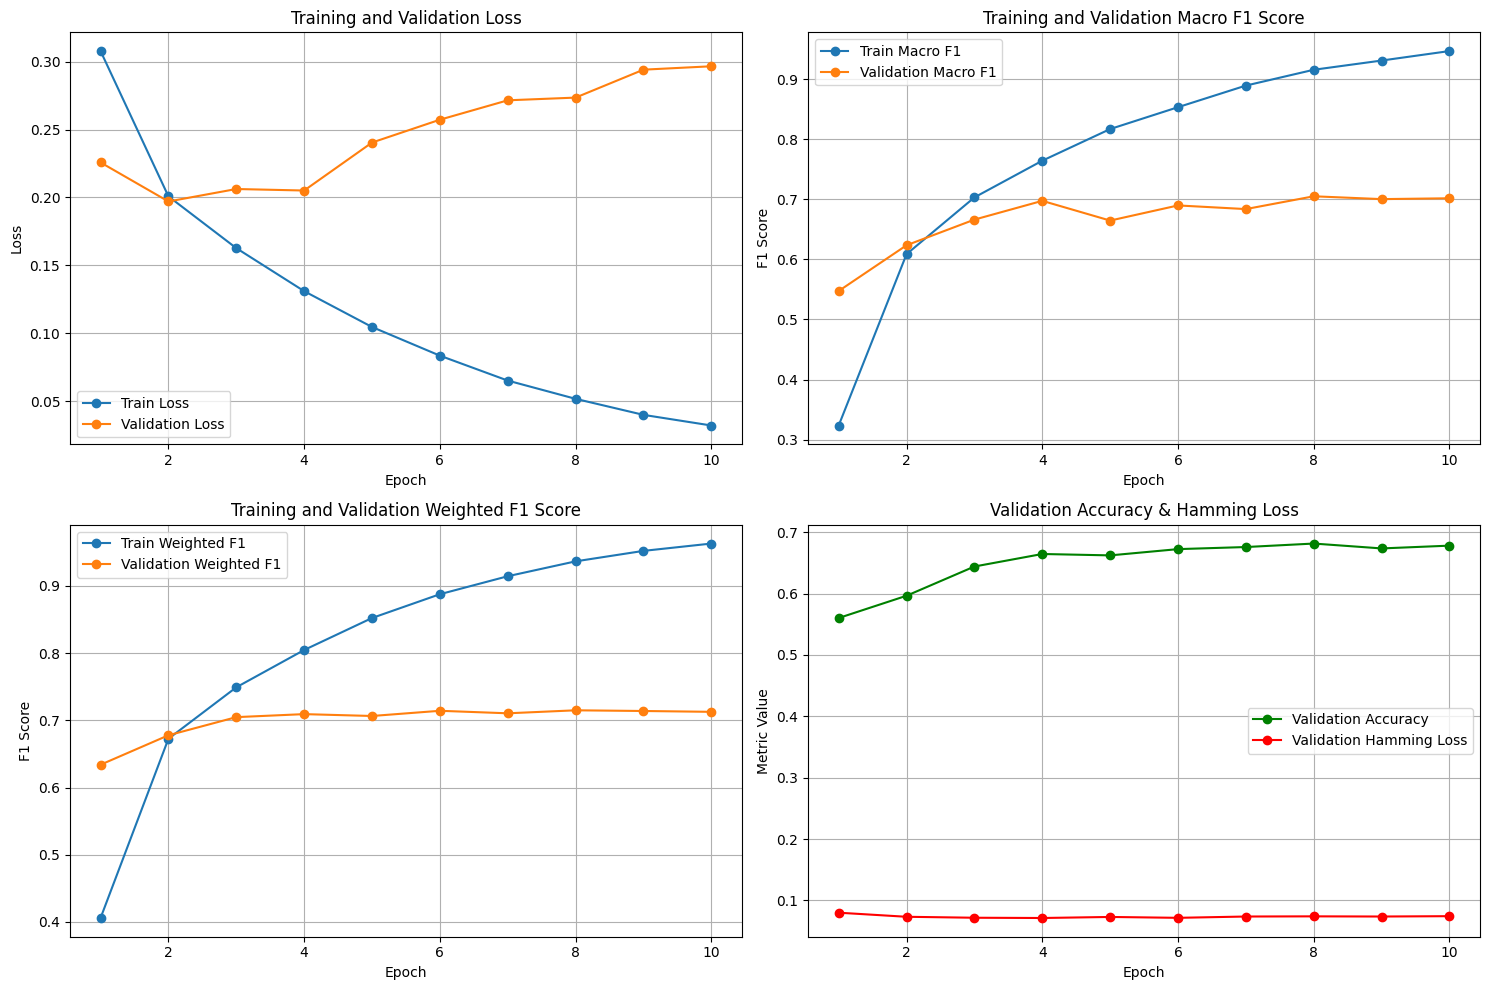

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating (validation_best):   0%|          | 0/111 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Evaluating (test_best):   0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEBUG: run_pipeline function returned
DEBUG: Pipeline completed successfully with valid returns
DEBUG: Memory cleanup completed
DEBUG: Cell 13 execution finished


In [14]:
# CELL 13: Execution Cell (WITH DEBUG OUTPUTS)

# --- Configuration for the Run ---
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# CHANGE THIS LINE TO SWITCH BETWEEN 'anxiety' and 'depression'
DATASET_CHOICE = 'anxiety'
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

USE_SEPARATE_TEST_FILE = True    # Use test.json if True, otherwise split train data
EPOCHS_TO_RUN = 10 # Adjust as needed (e.g., 5 for testing, 10-20 for full run)
BATCH_SIZE_TO_USE = 8           # Adjust based on GPU memory (T4 might handle 8 with len 512)
VALIDATION_SPLIT = 0.1          # Ratio for validation split (from train or train_val)
TEST_SPLIT = 0.2                # Ratio for test split (only if USE_SEPARATE_TEST_FILE=False)

# --- Debug Output ---
print("DEBUG: Starting cell 13 execution")
print(f"DEBUG: Selected dataset: {DATASET_CHOICE}")
print(f"DEBUG: Running on device: {device}")

# --- Run the Pipeline ---
# Clear memory before starting
gc.collect()
if device == torch.device('cuda'):
    torch.cuda.empty_cache()

# Try-except wrapper to catch and display any errors
try:
    print("DEBUG: About to call run_pipeline function...")
    
    # Call the main pipeline function
    trained_model, trained_tokenizer, trained_label_encoder = run_pipeline(
        dataset_type=DATASET_CHOICE,
        use_test_set=USE_SEPARATE_TEST_FILE,
        val_split_ratio=VALIDATION_SPLIT,
        test_split_ratio=TEST_SPLIT,
        batch_size_override=BATCH_SIZE_TO_USE,
        num_epochs_override=EPOCHS_TO_RUN
        # embedding_model_name and base_model_name use defaults from function definition
    )
    
    print("DEBUG: run_pipeline function returned")
    
    # --- Post-Training ---
    if trained_model and trained_tokenizer and trained_label_encoder:
        print("DEBUG: Pipeline completed successfully with valid returns")
        logger.info("Pipeline completed successfully. Model, tokenizer, and label encoder are available.")

        # Example: Using the 'predict' function (uncomment to use)
        # Determine if the run was multi-label based on the choice made
        # is_multi = (DATASET_CHOICE == 'depression')
        # Define sample input
        # sample_text = "This meme about feeling overwhelmed really resonates"
        # sample_triples = "Mental State: overwhelmed\nCause-Effect: seeing meme causes resonance" # Example triples
        # Make prediction
        # prediction_output = predict(
        #       trained_model, trained_tokenizer, trained_label_encoder,
        #       sample_text, sample_triples, device=device, is_multilabel=is_multi
        # )
        # logger.info(f"Example Prediction Output: {prediction_output}")

    else:
        print("DEBUG: Pipeline returned None values")
        logger.error("Pipeline did not complete successfully. Check logs for errors. trained_model might be None.")

except Exception as e:
    import traceback
    print(f"DEBUG: EXCEPTION CAUGHT: {type(e).__name__}: {e}")
    print("DEBUG: Traceback:")
    traceback.print_exc()
    print("DEBUG: Pipeline execution failed with the above error")

# Optional: Clean up memory again after potentially using the model
try:
    if 'trained_model' in locals() and trained_model is not None: del trained_model
    if 'trained_tokenizer' in locals() and trained_tokenizer is not None: del trained_tokenizer
    if 'trained_label_encoder' in locals() and trained_label_encoder is not None: del trained_label_encoder
except NameError:
    pass # Variables might not exist if pipeline failed early

print("DEBUG: Memory cleanup completed")
gc.collect()
if device == torch.device('cuda'):
    torch.cuda.empty_cache()

print("DEBUG: Cell 13 execution finished")

In [15]:
# CELL TO ZIP OUTPUT (Place after the main execution cell)

# --- Determine paths based on the DATASET_CHOICE from the previous execution cell ---
# Ensure DATASET_CHOICE is defined (it should be if the previous cell ran)
try:
    output_subdir = DATASET_CHOICE # Should be 'anxiety' or 'depression'
except NameError:
    print("Error: DATASET_CHOICE variable not found. Please run the main pipeline cell first.")
    # Optionally set a default or raise an error
    output_subdir = "anxiety" # Defaulting to anxiety, adjust if needed
    print(f"Warning: Defaulting to '{output_subdir}' for zipping.")

# Define the source directory to zip and the name for the output zip file
source_path = f"/kaggle/working/{output_subdir}/output/knowledge_fusion/"
zip_filename = f"/kaggle/working/{output_subdir}_output.zip" # e.g., /kaggle/working/depression_output.zip

print(f"Attempting to zip contents of: {source_path}")
print(f"Creating archive named: {zip_filename}")

# --- Create the zip archive ---
# Use the dynamically created paths
# -r for recursive, -q for quiet (optional, remove -q to see file list during zipping)
!zip -r -q {zip_filename} {source_path}

print(f"\nZip process finished for {output_subdir}.")

# --- Verify by listing the working directory ---
print("\nContents of /kaggle/working/:")
!ls -lh /kaggle/working/

Attempting to zip contents of: /kaggle/working/depression/output/knowledge_fusion/
Creating archive named: /kaggle/working/depression_output.zip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Zip process finished for depression.

Contents of /kaggle/working/:
total 948M
drwxr-xr-x 3 root root 4.0K Apr 12 13:57 depression
-rw-r--r-- 1 root root 948M Apr 12 17:02 depression_output.zip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
